# Main.pynb

using PyTorch version  0.4.0

This is the main notebook that will be dealing with the portion of the project currently being tested or under development.


In [1]:
import pickle
import random
import numpy as np
import torchtext.vocab as vocab
from carsonNLP.embedding import Vocabulary
from carsonNLP.string_token_functions import *

import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

print('you are using PyTorch version ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print('you have at least 1 GPU')
else:
    use_cuda = False
    print('no GPUs detected')

%load_ext autoreload
%autoreload 2
%matplotlib inline

you are using PyTorch version  0.4.0
you have at least 1 GPU


# Load the data

Currently the data is stored in memory in dictionaries for the training validation and test set
where the key is the class and the value is a list of all the strings corresponding to that class

For the notebook that generates this dataset, see the data_preprocess folder and RS_to_data_dict.ipynb

emotrvaltest9.p
index of first validation sample -1100
index of first test sample -1000
addiction 71785
anxiety 81293
autism 28292
bipolar 61506
conversation 2118284
depression 179615
happy 50533
jokes 538659
schizophrenia 14137
selfharm 73660

Total = 3217764

In [2]:
training_dict, validation_dict, test_dict, all_data, all_categories  \
= pickle.load( open( "trvaltest/trvaltest_10cl_5-100words.p", "rb" ) )
#= pickle.load( open( "trvaltest/emotrvaltest6.p", "rb" ) )


print(len(validation_dict['autism']))
print(validation_dict['happy'][4])
#all_categories = all_categories2
print(all_categories)

def min_max(data_dict, mini, maxi):
    for key in data_dict.keys():
        data_dict[key] = [line for line in data_dict[key] if len(line.split(' ')) in range(mini,maxi)]
        print(key,len(data_dict[key]))
    return data_dict

def count_samples(data_dict):
    count = 0
    for key in data_dict.keys():
        count += len(data_dict[key])
    print(count)
    return count

count = count_samples(training_dict)
'''
mini = 16
maxi = 32

training_dict = min_max(training_dict, mini,maxi)
validation_dict = min_max(validation_dict, mini,maxi)
test_dict = min_max(test_dict, mini,maxi)
'''

100
group donates 90 defibrillators to indiana state police
['addiction', 'anxiety', 'autism', 'bipolar', 'conversation', 'depression', 'happy', 'jokes', 'schizophrenia', 'selfharm']
2285377


'\nmini = 16\nmaxi = 32\n\ntraining_dict = min_max(training_dict, mini,maxi)\nvalidation_dict = min_max(validation_dict, mini,maxi)\ntest_dict = min_max(test_dict, mini,maxi)\n'

In [3]:
new_dict = {}
new_dict["happy"] = [
" i have discovered my life's purpose  " ,
" i am no longer sad , i never was worthless, i wasnt alone, i havent been wasting my life, I will make a better world ",
" i am not sad , i not worthless, i am not alone, I can change the world " ,
" i have friends ",
" i am not alone " ,
" the future looks bright ",
" i care about other people and our future " ,
" my optimism is regaining it's strength " ,
" there is a big world out there full of different people and my most interesting days have yet to be experienced" ,
" i am more optimistic nowdays ",
" i have been feeling more optimistic recently",
" tomorrow will be better ",
" all the darkness, hopelessness, insecurity, abuse, shame, and loneliness, was all part of a beautiful drama that shaped and molded me into who I am today and allows me to empathize with the pain of others. \
Without it I would never have realized my true calling in life, to connect, heal and unite people ",
" love, success, friendship, will be mine ", 
" love, success, friendship, was meant for me"
]

new_dict["depression"] = [
"  i have no friends"  ,
" i am alone ",
" happiness was not meant for me" ,
" love, success, friendship, will never be mine ", 
" love, success, friendship, just wasnt meant for me"

]

validation_dict["happy"].extend(new_dict["happy"])
validation_dict["depression"].extend(new_dict["depression"])

for i in range(2):
    training_dict["happy"].extend(new_dict["happy"])
    training_dict["depression"].extend(new_dict["depression"])

## index2word, word2index, embedding
Load the word embedding and the dictionaries for converting back and forth between the word as a string and it's index, the index2word has 4 more indices in it than the word2index because index2word has these extra tokens:

1. padding extra space, PAD, indexed at 0
2. start of sentence, SOS, indexed at 1
3. end of sentence, EOS, indexed at 2
4. unknown token, UNK, indexed at 3

To understand how the Vocabulary() class generates these embeddings and determine our vocabulary, see embedding.ipynb, to make a new set of index2word, word2index and embedding run this (requires torchtext):

`
glove = vocab.GloVe(name='6B', dim=100) # available in 100
print('Loaded {} words'.format(len(glove.itos)))
vocabClass = Vocabulary()
min_word_count = 5
path_to_folder_of_text = 'subreddit_posts'
index2word, word2index, embedding = vocabClass.makeEmbedding(min_word_count, glove, path_to_folder_of_text)
dicts_embed = (index2word, word2index, embedding)
pickle.dump(dicts_embed, open("embeddings/dicts_embed.p", "wb" ) )
`

In [4]:
index2word, word2index, embedding  = pickle.load( open( "embeddings/dicts_embed_min40_folder4.p", "rb" ) )
vocabClass = Vocabulary()
vocabClass.index2word = index2word
vocabClass.word2index = word2index

In [5]:
vocabClass.word2index["youre"]

9754

## Functions that support Training

Before we get started training lets go over some of the functions we will import to assist with the training process. If you look below at a few of the training / validation sentences you can see that in the raw data we have not yet made all the words lowercase and we have not added a space between the last word and the ending punctuation, ie 'Home?' should be 'home ?' so that 'home' and '?' are recognized as 2 separate tokens rather than the UNK token. 

In [6]:
n_categories = len(all_categories)
print('n_categories =', n_categories)
category = random.choice(all_categories)
print('example of category: ',category)
print(validation_dict[category][0])
vocabClass.word2index['thats']

n_categories = 10
example of category:  happy
giving 100 roses to strangers ! ! valentines day in hawaii


19479

In [7]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        
        #self.fc1 = nn.Linear(hidden_size, hidden_size)
        
        self.fc1 = nn.Sequential(
                       nn.Linear(hidden_size*2, hidden_size),
                       #nn.BatchNorm1d(num_features=1), # NEW
                       nn.PReLU(),
                       nn.Linear(hidden_size, 1)
                    )

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)
        # print(' hidden.size(), encoder_outputs.size()', hidden.size(), encoder_outputs.size()) 
        # torch.Size([batch_size, hidden_size]) torch.Size([seq_len, batch_size, hidden_size])
        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, seq_len)) # B x S

        if use_cuda:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(seq_len):
                #attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))
                attn_energies[b, i] = self.score(hidden[b], encoder_outputs[i, b])

        attn_weights = F.softmax(attn_energies,dim=1).unsqueeze(1) # batch_size,1,seq_len
        
        return attn_weights 
    
    def score(self, hidden, encoder_output):
        #print(hidden.size(), encoder_output.size())
        #concat = torch.cat((hidden, encoder_output), 1)
        concat = torch.cat((hidden, encoder_output))
        energy = self.fc1(concat)
        return energy
        

In [8]:
class RNN(nn.Module):
    
    def __init__(self, hidden_size, embedding, output_size, num_layers = 3, bidirectional = False, 
                 train_embedding = True , dropout = 0.0):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(p=dropout) # p – probability of an element to be zeroed. Default: 0.5
        
        embedding = torch.from_numpy(embedding).float()
        
        if use_cuda:
            embedding.cuda()
        
        self.embedding = nn.Embedding(embedding.shape[0], embedding.shape[1])
        self.embedding.weight = nn.Parameter(embedding, requires_grad=train_embedding)
        self.gru = nn.GRU(embedding.shape[1], hidden_size, num_layers, 
                          bidirectional=bidirectional, dropout = dropout)
        
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1
        
        # make the initial hidden state learnable as well 
        hidden0 = torch.zeros(self.num_layers*num_directions, 1, self.hidden_size)
        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)
        
        self.num_cells = num_layers*num_directions
        
        self.fc_concat = nn.Sequential(
                             nn.Linear(hidden_size * 2, hidden_size),
                             nn.BatchNorm1d(num_features=self.hidden_size)
                             ) 
        
        self.fc1 = nn.Sequential(
                       nn.Linear(self.hidden_size,self.hidden_size),
                       nn.BatchNorm1d(num_features=self.hidden_size),
                       )
        
        self.out = nn.Linear(hidden_size,output_size)
        self.prelu = nn.PReLU()
        self.attn = Attn(hidden_size)

    def forward(self, input_seqs):
        
        batch_size = input_seqs.size(1)
        hidden = self.hidden0.repeat(1, batch_size, 1)
        self.embedded = self.embedding(input_seqs)
        encoder_outputs, last_seq_hidden = self.gru(self.embedded, hidden)
        last_hidden = last_seq_hidden[-1] 
        
        attn_weights = self.attn(last_hidden, encoder_outputs) #  batch_size,1,seq_len
        
        # output of GRU (seq_len, batch_size, hidden_size) -> (batch_size, seq_len, hidden_size)
        encoder_outputs_bsh = encoder_outputs.transpose(0, 1)
        
        # bmm does operation (b,1,s).bmm(b,s,h) = (b,1,h)
        context = torch.bmm(attn_weights,encoder_outputs_bsh) # should be  # B x S=1 x N
        
        # Attentional vector using the RNN hidden state and context vector concatenated together 
        context = context.squeeze(1)       # B x S=1 x H -> Batch Size x Hidden Size
        concat_input = torch.cat((last_hidden, context), 1) # both should be batch_size x hidden_size
        
        concat_output = F.tanh(self.fc_concat(concat_input)) # <hidden_size>

        fc1 = self.fc1(concat_output)

        output = self.out(self.dropout(self.prelu(fc1)))
        
        return output, fc1 , attn_weights

# trained models

## v5 naming convention: `attn_v5_(number of hidden units)_(number of layers)`


## Once the accuracy is plateau'd on a learning rate decay from 0.01-0.001 and batch size 32 - 64 , good for fine tuning is a learning rate of 0.00025 - 0.0001 with batch size 2 - 8 

For example:

batch_size = 8, 
learning_rate = 0.00025,
gamma = 0.96

In [9]:
n_hidden = 1024
num_layers = 4
bidirectional = False

rnn = RNN( n_hidden, embedding, n_categories, num_layers = num_layers, 
          bidirectional = bidirectional, dropout = 0.3)

criterion = nn.CrossEntropyLoss()

if use_cuda:
    rnn = rnn.cuda()

name = 'trvaltest_10cl_5-100w_embed_min40_v0_'+str(n_hidden)+'_'+str(num_layers)


In [10]:
def eval_dict(vocabClass,data_dict):
    rnn.train(False)
    count = 0
    total_loss = 0
    total_correct = 0
    
    for category in data_dict.keys():
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        if use_cuda:
            category_tensor = category_tensor.cuda()
        for line in data_dict[category]:
            line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
            #print(line_tensor.size())
            if use_cuda:
                line_tensor = line_tensor.cuda()
            output, vector_rep, attn_wts = rnn(line_tensor)
            loss = criterion(output, category_tensor)
            total_loss += loss
            count += 1
            topv, topi = output.data.topk(1, 1, True)
            category_index = topi[0][0]
            if category == all_categories[category_index]:
                total_correct += 1
                
    avg_loss = float(total_loss)/count
    accuracy = float(total_correct)/count
    
    return avg_loss, accuracy

def random_training_batch(batch_size,vocabClass):
    
    category_tensor = torch.LongTensor(batch_size).random_(1)
    input_seqs = []
    
    for b in range(batch_size):
        category = random.choice(all_categories)
        category_tensor[b] = all_categories.index(category)
        line = random.choice(training_dict[category])
        input_seqs.append(indexesFromSentence(vocabClass, line))
        
    input_lengths = [len(s) for s in input_seqs]
    
    input_padded = [pad_seq(s, max(input_lengths), vocabClass) for s in input_seqs]
        
    category_tensor = Variable(category_tensor)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    # print(input_var.size()) <max_length, batch_size>
    if use_cuda:
        input_var = input_var.cuda()
        category_tensor = category_tensor.cuda()
        
    return category_tensor, input_var, input_lengths

def save_model(rnn,name):

    torch.save(rnn.state_dict(), "modelstate/"+name+".pth")
    rnncpu = rnn.cpu()
    torch.save(rnncpu.state_dict(), "modelstate/"+name+"_cpu.pth")
    rnn.cuda()

# https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html
    
def train(category_tensor, line_tensor, rnn, max_norm, norm_type):
    rnn.zero_grad()
    rnn.train(True)
    output, vector_rep, attn_wts = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    #total_norm = max(p.grad.data.abs().max() for p in rnn.parameters())
    #print(total_norm.cpu().numpy())
    param_norm = torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm , norm_type=norm_type)
    #total_norm = max(p.grad.data.abs().max() for p in rnn.parameters())
    #print(total_norm.cpu().numpy())
    optimizer.step()
    return output, loss.item(), param_norm.cpu().numpy() #loss.data[0], param_norm

def train2(category_tensor, line_tensor, rnn, clip = 0.1):
    rnn.zero_grad()
    rnn.train(True)
    output, vector_rep, attn_wts = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    #param_norm = torch.nn.utils.clip_grad_norm_(rnn.parameters(), 10 , norm_type=2)
    #print("param norm: ", param_norm.cpu().numpy())
    for p in rnn.parameters():
        p.grad.data.clamp_(max=clip)
    #param_norm = torch.nn.utils.clip_grad_norm_(rnn.parameters(), 10 , norm_type=2)
    #print("param norm: ", param_norm.cpu().numpy())
    optimizer.step()
    return output, loss.item()

In [12]:
name = 'trvaltest_10cl_5-100w_embed_min40_v2_'+str(n_hidden)+'_'+str(num_layers)

rnn.load_state_dict(torch.load("modelstate/"+name+".pth"))
avg_val_loss, val_accuracy = eval_dict(vocabClass,validation_dict)
print('avg_val_loss %.4f ,  val_accuracy %.4f' % (avg_val_loss, val_accuracy)) 

avg_val_loss 1.8824 ,  val_accuracy 0.3971


In [13]:
import time
import math

n_epochs = 102400*5
plot_every = 512
batch_size = 32
learning_rate = 0.001
gamma = 0.95
step_size=n_epochs/50
L2_reg = 1e-5
clip = 1.0
norm_type = 2 # "inf"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=L2_reg)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Keep track of losses for plotting
start = time.time()

current_loss = 0
all_losses = []
current_vloss = 0
all_vlosses = []

#name = 'tvt10_em4_'+str(n_hidden)+'_'+str(num_layers) 
#rnn.load_state_dict(torch.load("modelstate/"+name+".pth"))
best_val_accuracy =  val_accuracy
#avg_val_loss, best_val_accuracy = eval_validation(vocabClass)
#print('avg_val_loss %.4f ,  val_accuracy %.4f' % (avg_val_loss, best_val_accuracy))
print('last LR  %.6f' % (gamma**(n_epochs/step_size)*learning_rate))
print('estimates time ', (batch_size*n_epochs)/(3000*60), ' hours')
#param_norm = torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
#print("param norm: ", param_norm)

#total_norm = max(p.grad.data.abs().max() for p in rnn.parameters())
#print(total_norm)

name = 'trvaltest_10cl_5-100w_embed_min40_v2_'+str(n_hidden)+'_'+str(num_layers)


last LR  0.000077
estimates time  91.02222222222223  hours


In [14]:
#category_tensor, input_var, input_lengths = random_training_batch(batch_size,vocabClass)
#output, loss, param_norm = train(category_tensor, input_var, rnn, max_norm = 0.1, norm_type = "inf")
#print("param norm: ", param_norm.cpu().numpy())
#avg_val_loss, val_accuracy = eval_dict(vocabClass,validation_dict)
#print('avg_val_loss %.4f ,  val_accuracy %.4f' % (avg_val_loss, val_accuracy)) 
#rnn.zero_grad()
#param_norm = torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
#print("param norm: ", param_norm.cpu().numpy())

## Training Loop

training take a long time and progress at the end is more sparse, to give you an idea, a 256 hidden unit, 2 layer RNN with the attention FFNN's at the end training for 32000 batches at 8 samples a batch takes 199 minutes. so 256000 samples takes 

In [15]:
for epoch in range(1, n_epochs + 1):

    category_tensor, input_var, input_lengths = random_training_batch(batch_size,vocabClass)
    output, loss, param_norm = train(category_tensor, input_var, rnn, max_norm = clip, norm_type = norm_type)
    #output, loss= train2(category_tensor, input_var, rnn, clip = clip)
    current_loss += loss

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        avg_val_loss, val_accuracy = eval_dict(vocabClass,validation_dict)
        current_vloss += avg_val_loss
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print('saving model...')
            save_model(rnn,name)
            print('avg_val_loss %.4f ,  val_accuracy %.4f' % (avg_val_loss, val_accuracy))
            
        print('epoch %d, prm nrm: %.4f, val acc: %.4f, validation loss: %.4f, training loss: %.4f  %d%% (%s)' % (epoch, 
               param_norm, val_accuracy, avg_val_loss,
               current_loss / plot_every, epoch / n_epochs * 100, time_since(start)))
        all_losses.append(current_loss / plot_every)
        all_vlosses.append(current_vloss)
        current_loss = 0
        current_vloss = 0
        
    scheduler.step()
    
#avg_val_loss, val_accuracy = eval_dict(vocabClass,validation_dict)
#print('avg_val_loss %.4f ,  val_accuracy %.4f' % (avg_val_loss, val_accuracy)) 
plt.figure()
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Cross Entropy Loss', fontsize=25)
plt.plot(all_losses, label='train')
plt.plot(all_vlosses, label='val')
plt.legend()
plt.show()

epoch 512, prm nrm: 1.7626, val acc: 0.3431, validation loss: 1.8265, training loss: 1.5519  0% (16m 8s)
saving model...
avg_val_loss 1.8226 ,  val_accuracy 0.4108
epoch 1024, prm nrm: 1.5732, val acc: 0.4108, validation loss: 1.8226, training loss: 1.4656  0% (32m 3s)
saving model...
avg_val_loss 1.6844 ,  val_accuracy 0.4412
epoch 1536, prm nrm: 1.7469, val acc: 0.4412, validation loss: 1.6844, training loss: 1.4290  0% (48m 4s)
saving model...
avg_val_loss 1.5282 ,  val_accuracy 0.4814
epoch 2048, prm nrm: 1.2894, val acc: 0.4814, validation loss: 1.5282, training loss: 1.3870  0% (64m 8s)
saving model...
avg_val_loss 1.5330 ,  val_accuracy 0.5108
epoch 2560, prm nrm: 1.3940, val acc: 0.5108, validation loss: 1.5330, training loss: 1.3571  0% (80m 7s)
epoch 3072, prm nrm: 1.4404, val acc: 0.4608, validation loss: 1.7492, training loss: 1.3148  0% (96m 4s)
epoch 3584, prm nrm: 1.3661, val acc: 0.4765, validation loss: 1.5633, training loss: 1.2992  0% (112m 6s)
epoch 4096, prm nrm: 0

epoch 35328, prm nrm: 1.1059, val acc: 0.5510, validation loss: 1.5831, training loss: 0.8988  6% (1109m 2s)
epoch 35840, prm nrm: 1.1041, val acc: 0.5716, validation loss: 1.5215, training loss: 0.9148  7% (1125m 7s)
epoch 36352, prm nrm: 1.8349, val acc: 0.5431, validation loss: 1.5025, training loss: 0.8907  7% (1141m 8s)
epoch 36864, prm nrm: 3.4034, val acc: 0.5784, validation loss: 1.5962, training loss: 0.9013  7% (1157m 21s)
epoch 37376, prm nrm: 0.9880, val acc: 0.5755, validation loss: 1.4988, training loss: 0.8961  7% (1173m 19s)
epoch 37888, prm nrm: 1.0127, val acc: 0.5735, validation loss: 1.4967, training loss: 0.8957  7% (1189m 23s)
saving model...
avg_val_loss 1.4756 ,  val_accuracy 0.5833
epoch 38400, prm nrm: 0.9951, val acc: 0.5833, validation loss: 1.4756, training loss: 0.9017  7% (1205m 27s)
epoch 38912, prm nrm: 1.4103, val acc: 0.5735, validation loss: 1.5488, training loss: 0.8910  7% (1221m 44s)
epoch 39424, prm nrm: 1.3030, val acc: 0.5745, validation loss: 

epoch 72704, prm nrm: 0.9518, val acc: 0.5745, validation loss: 1.6150, training loss: 0.7257  14% (2286m 52s)
epoch 73216, prm nrm: 1.9895, val acc: 0.5676, validation loss: 1.7029, training loss: 0.7231  14% (2302m 50s)
epoch 73728, prm nrm: 1.0847, val acc: 0.5784, validation loss: 1.6087, training loss: 0.7427  14% (2318m 55s)
epoch 74240, prm nrm: 0.8538, val acc: 0.5676, validation loss: 1.7160, training loss: 0.7197  14% (2335m 11s)
epoch 74752, prm nrm: 1.2178, val acc: 0.5882, validation loss: 1.5996, training loss: 0.7228  14% (2351m 21s)
epoch 75264, prm nrm: 1.3018, val acc: 0.5637, validation loss: 1.7704, training loss: 0.7284  14% (2367m 37s)
epoch 75776, prm nrm: 0.9694, val acc: 0.5853, validation loss: 1.7014, training loss: 0.7254  14% (2383m 41s)
epoch 76288, prm nrm: 1.7736, val acc: 0.5765, validation loss: 1.7046, training loss: 0.7300  14% (2399m 41s)
epoch 76800, prm nrm: 1.1481, val acc: 0.5647, validation loss: 1.6401, training loss: 0.7144  15% (2415m 56s)
e

epoch 110592, prm nrm: 1.8729, val acc: 0.5794, validation loss: 1.9830, training loss: 0.6140  21% (3485m 1s)
epoch 111104, prm nrm: 2.0650, val acc: 0.5657, validation loss: 1.9184, training loss: 0.6148  21% (3501m 15s)
epoch 111616, prm nrm: 2.5532, val acc: 0.5598, validation loss: 1.9133, training loss: 0.6007  21% (3517m 38s)
epoch 112128, prm nrm: 1.6458, val acc: 0.5569, validation loss: 1.7789, training loss: 0.6029  21% (3533m 54s)
epoch 112640, prm nrm: 2.1075, val acc: 0.5686, validation loss: 1.9426, training loss: 0.6084  22% (3550m 7s)
epoch 113152, prm nrm: 3.5633, val acc: 0.5735, validation loss: 1.9000, training loss: 0.6005  22% (3566m 23s)
epoch 113664, prm nrm: 0.9734, val acc: 0.5706, validation loss: 1.8604, training loss: 0.5996  22% (3582m 43s)
epoch 114176, prm nrm: 1.8983, val acc: 0.5824, validation loss: 1.9070, training loss: 0.6040  22% (3598m 52s)
epoch 114688, prm nrm: 2.8834, val acc: 0.5618, validation loss: 1.9749, training loss: 0.5914  22% (3615m

epoch 148480, prm nrm: 1.4419, val acc: 0.5647, validation loss: 1.9572, training loss: 0.5255  28% (4682m 48s)
epoch 148992, prm nrm: 1.1007, val acc: 0.5588, validation loss: 1.9809, training loss: 0.5177  29% (4698m 59s)
epoch 149504, prm nrm: 2.5484, val acc: 0.5569, validation loss: 2.0415, training loss: 0.5203  29% (4715m 19s)
epoch 150016, prm nrm: 3.5772, val acc: 0.5500, validation loss: 2.1197, training loss: 0.5167  29% (4731m 40s)
epoch 150528, prm nrm: 2.0873, val acc: 0.5549, validation loss: 2.0942, training loss: 0.5136  29% (4747m 57s)
epoch 151040, prm nrm: 2.3489, val acc: 0.5490, validation loss: 2.1542, training loss: 0.5059  29% (4764m 1s)
epoch 151552, prm nrm: 1.9370, val acc: 0.5618, validation loss: 2.0594, training loss: 0.5086  29% (4780m 10s)
epoch 152064, prm nrm: 1.8386, val acc: 0.5471, validation loss: 1.9171, training loss: 0.5304  29% (4796m 13s)
epoch 152576, prm nrm: 3.0540, val acc: 0.5441, validation loss: 1.9665, training loss: 0.5267  29% (4812

KeyboardInterrupt: 

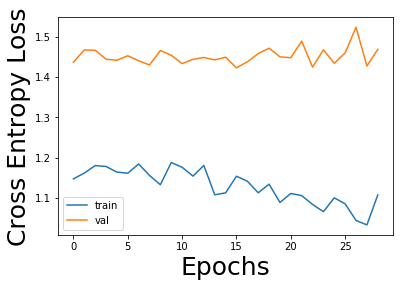

In [16]:
plt.figure()
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Cross Entropy Loss', fontsize=25)
plt.plot(all_losses, label='train')
plt.plot(all_vlosses, label='val')
plt.legend()
plt.show()

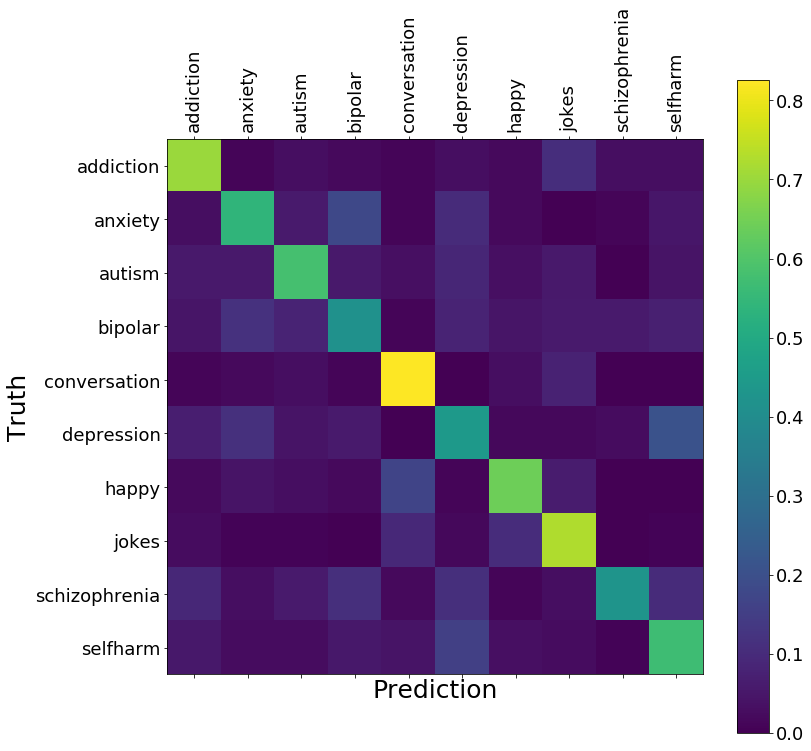

In [155]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

def random_training_pair(category_lines):                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
    if use_cuda:
        line_tensor = line_tensor.cuda()
        category_tensor = category_tensor.cuda()
    return category, line, category_tensor, line_tensor

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Just return an output given a line
def evaluate(line_tensor):
    rnn.train(False)
    output, rep, attn_wts = rnn(line_tensor)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
data_dict = test_dict
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair(data_dict)
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('Truth', fontsize=25)
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Confusion Matrix: actual language (rows) which language the network guesses (columns)

fig.savefig("confusionMatrix_v13.png")
 

In [15]:
avg_loss, accuracy = eval_dict(vocabClass,test_dict)
print('avg_val_loss %.4f ,  val_accuracy %.4f' % (avg_loss, accuracy))

avg_val_loss 1.2933 ,  val_accuracy 0.5933


In [91]:
def predict_line(line, vocabClass, rnn):
        line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
        if use_cuda:
            line_tensor = line_tensor.cuda()
        rnn.train(False)
        output, rep, attn_wts = rnn(line_tensor)
        guess, guess_i = category_from_output(output)
        return guess, output, attn_wts

In [107]:
#string = " I am not happy, I cannot feel joy, I havent been optimistic, I dont enjoy the things I used to "
string = " I am not happy" #
string = " I dont enjoy the things I used to "
prediction, output, attention_weights = predict_line(string, vocabClass, rnn)
print(prediction)
print(output.cpu().detach().numpy())
print(attention_weights.cpu().detach().numpy())
print(vocabClass.normalize_string(string))


depression
[[-1.5660154   1.3337743  -0.6406571  -0.97600603 -0.4812172   0.62176216
   0.32732072 -0.5785853 ]]
[[[0.00958077 0.00649086 0.01840404 0.00221633 0.09877513 0.12239128
   0.12400452 0.08030707 0.53783   ]]]
i dont enjoy the things i used to


In [156]:
def encode_data(data_dict,lang):
    
    emotype = {}
    index = 0
    
    for category in data_dict.keys():
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        if use_cuda:
            category_tensor = category_tensor.cuda()
        for line in  data_dict[category]:
            emotype[index] = {}
            emotype[index]['text'] = line
            emotype[index]['text_tokens'] = vocabClass.normalize_string(line)
            emotype[index]['label'] = category
            line_tensor = Variable(torch.LongTensor(indexesFromSentence(lang, line))).view(-1,1)
            if use_cuda:
                line_tensor = line_tensor.cuda()
            output, vector_rep, attention_weights = rnn(line_tensor)
            emotype[index]['attention_weights'] = attention_weights.cpu().detach().numpy()
            attn_weights = attention_weights.cpu().detach().numpy()[0][0][:-1]
            attn_weights = np.clip(attn_weights,0.0,2*np.mean(attn_weights))
            attn_weights /= np.sum(attn_weights)
            emotype[index]['rescaled_attention_weights'] = attn_weights
            emotype[index]['encoding'] = vector_rep.data.cpu().numpy()
            topv, topi = output.data.topk(1, 1, True)
            category_index = topi[0][0]
            emotype[index]['prediction'] = all_categories[category_index]
            emotype[index]['outputs'] = output.data.cpu().numpy()

            index += 1

    return emotype

In [158]:
import pickle
emotype = encode_data(validation_dict,vocabClass)
#emotype = eval_validation_vectors(category_lines_validation)
pickle.dump(emotype, open("text_encoding/emotype_v14_valset.p", "wb" ) )

In [120]:
def turn_attn_weight_into_color(weight, tmp_cmap):
    color_indx = int(255 * weight)
    r, g, b, alpha = [int(255 * tmp_cmap(color_indx)[i]) for i in range(4)]
    return(r, g, b)

def get_word_with_rgb(word, r, g, b):
    esc = "\x1b["
    txt_style = "2;"  # Text style ("1" is bold, "2" is not bold)
    toggle_bg = "48;2;"  # Switch to toggle background color (38;2; is foreground color)
    r = str(r)  # Red
    g = str(g)  # Green
    b = str(b)  # Blue
    ansi_code = esc + txt_style + toggle_bg + r + ";" + g + ";" + b + "m"
    return("%s%s" % (ansi_code, word))

def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

def predict_line(line, vocabClass, rnn):
        rnn.train(False)
        op_txt = ''
        my_cmap = plt.cm.get_cmap(name='Reds')
        tokens = re.split(' ', vocabClass.normalize_string(line))
        line_tensor = Variable(torch.LongTensor(indexesFromSentence(vocabClass, line))).view(-1,1)
        if use_cuda:
            line_tensor = line_tensor.cuda()
        output, rep, attn_wts = rnn(line_tensor)
        attn_weights = attn_wts.cpu().detach().numpy()[0][0][:-1]
        attn_weights = np.clip(attn_weights,0.0,2*np.mean(attn_weights))
        attn_weights /= np.sum(attn_weights)
        #print(attn_weights)
        guess, guess_i = category_from_output(output)
        for word_indx, word in enumerate(tokens):
            r, g, b = turn_attn_weight_into_color(attn_weights[word_indx], my_cmap)
            op_txt += get_word_with_rgb(word, r, g, b) + ' '
        # Note that we have to explicitly set the normal background to plain ol' white
        print('prediction: ', guess)
        print(op_txt + '\n')
        
        return guess, output, attn_wts

In [159]:
string = " i have only myself to blame" 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  selfharm
i have only myself to blame 



In [164]:
string = " i have discovered my life's purpose  " 

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  happy
i have discovered my lifes purpose ! 



In [162]:
string = "  i have  friends"  

prediction, output, attention_weights = predict_line(string, vocabClass, rnn)

prediction:  happy
i have friends 

